In [22]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import time

In [23]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4 #lowest learning rate.
EPOCHS = 2
BS = 32

In [24]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []

[INFO] loading images...


In [25]:
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]# label with_mask, without_mask
    #print(label)

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)#normalizing the image so it won't have any
    #biasnes data dependent pretrained weights
    #print(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

c:\users\ajalr\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [26]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)


In [27]:
# perform one-hot encoding on the labels
lb = LabelBinarizer() #creates a binary labels for class or no class
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print(labels)
#the first without mask is [0 1]; 0 = without mask, 1 = with mask, rows equal
#length of input vector and column equals number of classes.

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [28]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
test_size=0.20, stratify=labels, random_state=42) #use of strarify=labes makes
#sure that the random split has 25% zeros and 75% ones
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [29]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")


In [30]:
'''
for the image classification we will be using a pre-trained neural classfication
model called Mobilenet. It was created for computer vision classification where
the pixel from input image is converted into features/weights that defines the 
contents of the image. It was trained with 1.4 million images to seperated 
1000 images.
'''
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))


In [31]:
'''
Flatten layer: changes the matrix into a single array. i.e in our image of 224
* 224, to feed this multidimensional data we flatten this out to be 50,176 nodes/
neurons for further processing.

Dense layer:It is just the other name of hidden layers in Neural network. 
Syntax: keras.layers.Dense(units,activation = None), units is the output size
which in our case is 1 (0,1) (either mask or not)

Activation('sigmoid') layer: It is just a function that helps us to classify
the output of the function in either yes or no. 2 type liner and non linear
activation function and sigmoid is a non linear one equivalent to logistic re
-gression.

Dropout layer: It is a technique to dropping out nodes to prevent it from 
overoptiizing the weight and preventing overfitting without affecting other
nodes.

AveragePooling2D: It is a technique to downscale the pixel intensity from previous
layer to increase the performance.
Detail:https://www.machinecurve.com/index.php/2020/01/30/what-are-max-pooling-average-pooling-global-max-pooling-and-global-average-pooling/#what-are-pooling-operations
'''
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel) 
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)#relu is a better performace
#activation function than sigmoid.
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [32]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)


In [33]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [34]:
'''
Loss function: The use of the loss function in keras is to compute the quantity
that our model seek to minimize. It can be implemented via a class or function
handle. ex: BinaryCrossentrophy, CategorialCrossentrophy and many more.

Binary_crossentrophy: a class in loss function to minmize the loss between the 
predicted label and the true label. Should be a binary application(Mask or No
Mask)

Optimizers: Kathematical functions used to change the attributes of the neural
networks like weights/params and learning rate to reduce losses. ex: ADAM (adap
tive moment estimation), extension to stochastic gradient descent famous in 
deep learning and natural language processsing

Metrics: Keras metrics are functions that are used to evaluate the performance
of your deep learning model.ex: binary accuracy, categorialaccuracy etc. 
THE USE OF ACCURACY IN GENERAL IMPLIES THAT THE KERAS IS SMART ENOUGH TO CHOOSE
THE METRICS DEPENDING ON OUR TYPE OF LOSS.

'''
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),validation_steps=len(testX) // BS,epochs=EPOCHS)


[INFO] evaluating network...
[INFO] compiling model...
[INFO] training head...
Epoch 1/2
102/102 [==============================] - 207s 2s/step - loss: 0.4222 - accuracy: 0.8315 - val_loss: 0.1490 - val_accuracy: 0.9805
Epoch 2/2
102/102 [==============================] - 200s 2s/step - loss: 0.1556 - accuracy: 0.9617 - val_loss: 0.0826 - val_accuracy: 0.9841


In [35]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [36]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [37]:
testY.argmax(axis=1).shape

(819,)

In [38]:
#show a nicely formatted classification report
'''
testY.argmax(axis=1): True data that we divided above
predIdxs: predicted data from the classifier
target_names: the file names where our data lies.
returns:
support: the occurave of each label, macro and weighted are different averages
for teh accuracy.
'''
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       433
without_mask       0.99      0.98      0.98       386

    accuracy                           0.98       819
   macro avg       0.98      0.98      0.98       819
weighted avg       0.98      0.98      0.98       819



In [39]:
'''
we can also save this model and use it on any test example
.h5 indicated the Hierarchical data format containing multidimensional arrays 
of scientific data
'''
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


In [40]:
#the result from our modified model built on top of the base model.
H.history

{'loss': [0.42216184735298157, 0.155570387840271],
 'accuracy': [0.8315334916114807, 0.9617401957511902],
 'val_loss': [0.14903950691223145, 0.08259649574756622],
 'val_accuracy': [0.980463981628418, 0.9841269850730896]}

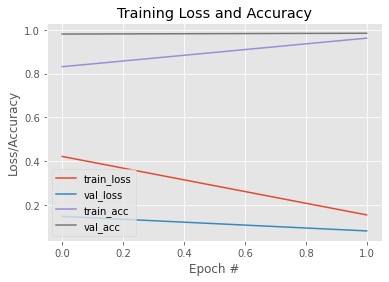

In [41]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

